# Spatially varying explanations behind Brexit voting

*Originally written by Roger Beecham in 2016, adapted to Python by Rafael Henkin in 2019.*

In this extended practical session you’ll be doing some visual analytics in Python. The practical uses some libraries that you should be now familiar with (Pandas), but we also use some other libraries to support the analysis, such as Altair for state-of-the-art charting in Python, Geopandas to extend Pandas with support for geographical data and statsmodels for linear regression.

Aspects of the session that expose the data analysis process, the reasoning and interepretation of graphical output given research questions, will be of interest as they could be used as a reference for the individual coursework. The practical will cover a topic that is still in the news: the UK’s referendum vote on membership of the EU.

## Introduction

The narrow vote in favour of Leave was a shock to many. You've probably heard commentators remark on the underlying causes for why people voted as they did. These pronouncements have often been made based on the very obvious [geographic differences](http://www.bbc.co.uk/news/uk-politics-36616028) in voting preference. A familiar caricature in the media is of Leave voting being a symptom of blue collar disaffection and Remain voting of liberal values and (relative) affluence. But is this borne out in the data?

Our research questions are:

 * Can we account for geographical differences in the referendum results using demographic data?
 * Can we explain the referendum results in terms of the characteristics of the population?
 * Do these explanations vary geographically?

Here we'll take a single outcome variable -- the share of vote in favour of Leave in each GB Local Authority (LA) -- and study the extent to which key sociology-economic variables from the 2011 Census might help explain this outcome. Using geographically-weighted statistics we'll investigate how the relationships in candidate explanations vary geographically.  Note that we're not looking at individual behaviour here. We're looking at data aggregated at Local Authority (LA) level and can only attempt *explain* differences in voting prefence at this level. 

## How this applies to your coursework

This practical is mainly about how to use and implement methods in Python. Don't forget that your coursework will need motivation, research questions and perhaps recommended actions that result from your findings.

For this practical, one *motivation* is that although the overall Remain:Leave vote was about 48:52, this ratio was certainty not uniformly spread. Every LA in Scotland voted to Remain, for example, and so too did inner London and parts of Northern Ireland. Motivating this study is better *understanding* as to what might drive these differences.

We could come up with *research questions* such as:

 * Did Scotland vote differently from the rest of the UK given its population structure? (Is Scotland different?)
 * Are the factors that drove the vote the same everywhere in the Great Britain?

This practical is about the *analytic tasks* chosen to answer such questions and the *visual analytics methods* that can be employed to carry out these tasks. A particular set of approaches is used here, but you should consider others that you've been exposed to in this module, plus those discovered during your group work literature reviews earlier this term.

The following analytical tasks will help address these research questions:

 * To *describe* how the referedum results vary geographically and how they *relate* to demographic variables
 * To *choose* demographic variables for which there are is a theoretical and a data-driven reason for using them
 * To build *models* to explore the population characteristics that appear to *drive* the referendum results and to assess their *quality*
 * To build *geographically-weighted* models to explore whether these relationships vary geographically
 * To identify *parts of the country* with similar relationships between demographics and voting outcome

## Python preparation

In addition to familiar libraries such as numpy and pandas, we will make heavy use of [Altair](https://altair-viz.github.io/index.html) as our visualisation library of choice. There are of course other options, such as Matplotlib, Seaborn and Bokeh. Our main reason for using Altair is the fact that it produces, out-of-the-box, SVG graphics and JSON specifications of Vega-Lite charts, which are portable web-based graphics. Altair is essentially a Python API of Vega-Lite, which is part of the [Vega](https://vega.github.io/) family of visualisation grammars (think ggplot if you know R). These are state-of-the-art languages for *declaring* interactive graphics by mapping data variables to visual variables.

_Libraries below can be installed with the Anaconda navigator or_:  

    conda install libraryname      
    
_Sometimes you might need to install from the conda-forge channel:_  
    
    conda install -c conda-forge libraryname
_Sometimes you need to install from pip_:

    pip install libraryname

_You might also need to install dependencies such as Vega_:
    
    conda install -c conda-forge Vega

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import altair as alt
from IPython.display import Markdown, display
from itertools import combinations as combo
from matplotlib import pyplot as plt

#Linear regression
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Geographically weighted statistics
from pysal.model.mgwr.gwr import GWR,GWRResults
from pysal.model.mgwr.diagnostics import corr

#Clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score,silhouette_samples
from scipy.cluster.hierarchy import dendrogram

/Users/rafael/anaconda/envs/vapracticals/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [ ]:
#If you're using Jupyter Notebook, you need to run the command below
alt.renderers.enable('notebook')

Next load the results data (the outcome variable), the Census 2011 data that you'll use as explanatory variables and [shapefiles](https://en.wikipedia.org/wiki/Shapefile) containing details of LA boundaries for mapping. Note that referendum results are available only at local authority level -- so we will use Census 2011 variables that are aggregated to this resolution.

The code below results in:

 * a DataFrame ("census_data") where rows are LAs and columns are Census variables and LA information (such as the Region they are part of)
 * a DataFrame ("referendum_data") where rows are LAs and columns describe voting behavior in the Referendum 

In [3]:
referendum_data = pd.read_csv("data/referendum_data.csv")
census_data = pd.read_csv("data/2011_census_oa.csv")
lookup = pd.read_csv("data/oa_la_lookup.csv")
census_data = pd.merge(census_data,lookup);

We then aggregate the data and compute some statistical summaries that might be relevant. We use iloc to keep only the variables we want to use in our analysis.

In [4]:
grouped = census_data.groupby('LOCAL_AUTHORITY_CODE').sum();
grouped = grouped.assign(young_adults = (grouped["Age_20_to_24"] + grouped["Age_25_to_29"] +grouped["Age_30_to_44"])/grouped["Total_Population"] 
                        ,white = grouped["White_British_and_Irish"] /grouped["Total_Population"] 
                        ,christian = grouped["Christian"] /grouped["Total_Population"] 
                        ,english_speaking = grouped["Main_language_is_English_or_Main_language_not_English__Can_speak_English_very_well"]/grouped["Total_Population"]
                        ,single_ethnicity_household = grouped["All_household_members_have_the_same_ethnic_group"] /grouped["Total_Population"]
                        ,own_home = grouped["Owned_and_Shared_Ownership"]/grouped["Total_Population"]
                        ,not_good_health = (grouped["Fair_health"] + grouped["Bad_health"] + grouped["Very_bad_health"])/grouped["Total_Population"]
                        ,degree_educated = grouped["Highest_level_of_qualification_Level_4_qualifications_and_above"] /(grouped["Highest_level_of_qualification_Level_4_qualifications_and_above"]+grouped["Highest_level_of_qualification_Level_3_qualifications"]+grouped["Highest_level_of_qualification_Level_1_Level_2_or_Apprenticeship"]+grouped["No_qualifications"])                        
                        ,no_car = grouped["No_cars_or_vans_in_household"] / grouped["Total_Households"]
                        ,private_transport_to_work = grouped["Private_Transport"] / grouped["Total_Employment_16_to_74"]
                        ,professionals = (grouped["Managers_directors_and_senior_officials"] +grouped["Professional_occupations"]) / grouped["Total_Employment_16_to_74"])
#grouped = grouped.iloc[:,[0,74]] 
grouped = grouped.iloc[:,[0,74,75,76,77,78,79,80,81,82,83,84]]
#grouped.reset_index(inplace=True)

### Combining referendum results, census data and spatial data

The final part of the preparation is to load the shapefile that contains the geometry needed to draw our maps. This is done using geopandas, which creates a dataframe with spatial data.
We again use the merge function from pandas to merge everything together, but this time we specify the columns to match. We complete the preparation by setting up two additional variables: the difference between leave and remain in local authorities and population density, which might also be an explanatory variable for the vote.

In [5]:
gb = gpd.read_file("shapefiles/boundaries_gb.shp")
gb.crs = {'init': 'epsg:27700'}
gb.loc[gb["geo_code"]=="E41000052",'geo_code'] = "E06000052"
gb.loc[gb["geo_code"]=="E41000324",'geo_code'] = "E09000033"
gb_boundaries = pd.merge(gb,referendum_data,left_on='geo_code', right_on='Area_Code', how='inner')
gb_boundaries = pd.merge(gb_boundaries,grouped,left_on='geo_code', right_on='LOCAL_AUTHORITY_CODE', how='inner')
gb_boundaries = gb_boundaries.assign(leave_remain = gb_boundaries["Leave"]-0.5
                     ,pop_density = gb_boundaries["Total_Population"]/gb_boundaries["AREA"])

In [6]:
#Check if everything looks fine
gb_boundaries.head()

geo_labelw        geo_label   geo_code          AREA      PERIMETER  \
0       None   South Ayrshire  S12000028  1.222498e+09  271424.465207   
1       None  Huntingdonshire  E07000011  9.129696e+08  207912.519811   
2       None       Tewkesbury  E07000083  4.146167e+08  183303.084764   
3       None  West Lancashire  E07000127  3.473296e+08  111348.525350   
4       None       Darlington  E06000005  1.976383e+08   99068.282044   

                                            geometry Region_Code      Region  \
0  POLYGON ((243296 588978.1999999993, 242159.5 5...   S92000003    Scotland   
1  POLYGON ((507472.314 299057.906, 511995.531 29...   E12000006        East   
2  POLYGON ((381509.283 230085.397, 385473.094 23...   E12000009  South West   
3  POLYGON ((337708.438 420693.956, 337713.301 42...   E12000002  North West   
4  POLYGON ((419709.307 515678.312, 418911.5 5199...   E12000001  North East   

   Area_Code             Area  ...  english_speaking  \
0  S12000028   South Ayrshire  ...          0.879290   
1  E07000011  Huntingdonshire  ...          0.941183   
2  E07000083       Tewkesbury  ...          0.954481   
3  E07000127  West Lancashire  ...          0.955242   
4  E06000005       Darlington  ...          0.946118   

   single_ethnicity_household  own_home  not_good_health  degree_educated  \
0                    0.258415  0.313974         0.190418         0.251485   
1                    0.276011  0.294417         0.155527         0.294213   
2                    0.286589  0.319417         0.167482         0.314578   
3                    0.285667  0.301694         0.196811         0.264319   
4                    0.281403  0.288612         0.201953         0.247879   

     no_car  private_transport_to_work  professionals  leave_remain  \
0  0.260324                   0.646790       0.254784       -0.0896   
1  0.136169                   0.738221       0.292187        0.0424   
2  0.135939                   0.742008       0.287984        0.0325   
3  0.197726                   0.748578       0.281232        0.0531   
4  0.279666                   0.696209       0.246583        0.0618   

   pop_density  
0     0.000092  
1     0.000186  
2     0.000198  
3     0.000319  
4     0.000534  

[5 rows x 28 columns]

### Exploring spatial variation in the Leave:Remain vote

We first observe how voting preference – % share of Leave vote in GB LAs – varies geographically by plotting the raw scores on a map.

The code block below creates a Choropleth map of voting preference by local authority in Great Britain. We convert the geopandas dataframe to a format called *geojson*, which is compatible with the Altair visualisation library. A diverging colour scheme is used to differentiate between majority Leave:Remain, where brown areas have a remain majority and blue areas have a leave majority. 

In [7]:
data_geo = alt.InlineData(values = gb_boundaries.to_json(), #geopandas to geojson string
                       format = alt.DataFormat(property='features',type='json'))

The conversion into geojson splits columns of the dataframe into geographical column *features* and all other variables under *properties*, which are referenced below. In Altair, we need to specify the type of data for a column, much like we talked about in the first few weeks. The notation below uses the abbreviated version, in which we declare the type of the variable by a single letter after a colon: **N** for nominal, **O** for ordinal, **Q** for quantitative.

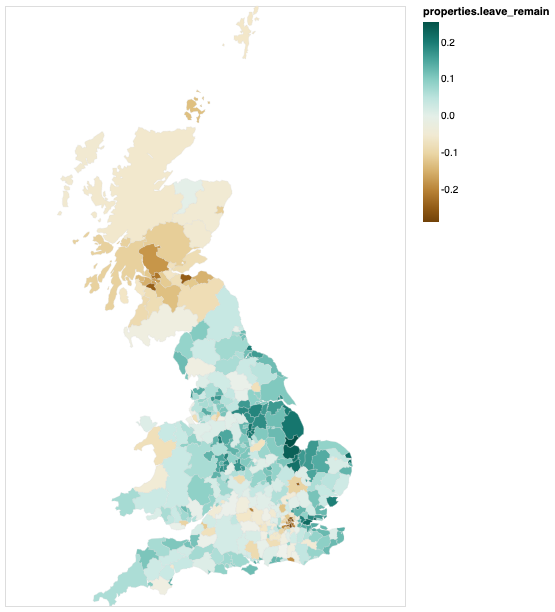

In [8]:
alt.Chart(data_geo).mark_geoshape(strokeWidth=1,stroke='lightgray',strokeOpacity=0.2
).encode(
    color=alt.Color('properties.leave_remain:Q', scale=alt.Scale(scheme='brownbluegreen')),
    tooltip=['properties.Area:N','properties.leave_remain:Q','properties.Region:N']
).properties(
    projection={'type': 'identity','reflectY': True},
    width=400,
    height=600
)

It is sometimes difficult to see the colours in smaller areas in choropleth maps, so we can filter the data before plotting and have a closer look at particular regions to understand better what is going on.

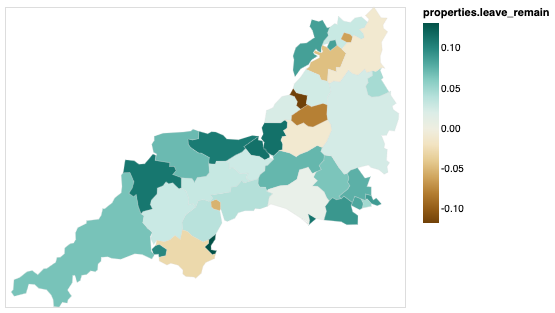

In [9]:
filtered_geo = alt.InlineData(values = gb_boundaries[gb_boundaries['Region'] == 'South West'].to_json(),                                                                                                     
                       format = alt.DataFormat(property='features',type='json'))

alt.Chart(filtered_geo
).mark_geoshape(strokeWidth=1,stroke='lightgray',strokeOpacity=0.2
).encode(
    color=alt.Color('properties.leave_remain:Q', scale=alt.Scale(scheme='brownbluegreen')),
    tooltip=['properties.Area:N','properties.leave_remain:Q']
).properties(
    projection={'type': 'identity','reflectY': True},
    width=400,
    height=300
)

### Explore for yourself

Despite seeing various iterations of these maps in the weeks after the referendum, the very obvious contrast between most of England and Wales (Leave) and Scotland and London, certain University cities and towns (Remain) is surprising. Notice the spot of dark brown in the East of England representing Cambridge.

* To what extent are these patterns associated with characteristics of the underlying population? Try plotting choropleth maps of some of the variables that we investigate in the next section (e.g. own_home)

* Can you come up with hypotheses as to why some areas voted the way they did?

## What drives Local Authority voting preference?

As we know, the 48:52 Remain:Leave vote was not the case everywhere. A caricature in the media is of Leave voting being a symptom of blue collar disaffection and Remain voting of liberal values and (relative) affluence. We hope to investigate these ideas in our modelling and identify 2011 Census variables, aggregated to the LA level, that we assume are discriminating:

| complexity | justification/theory |
|:--------------------:|:----------------:|
| *degree-educated* |                               |
| *professional occupations* | post-industrial / knowlegde economy |
| *younger adults* | |
|--------------------|----------------|
| *English speaking* | |
| *single-ethnicity* | |
| *not good health* | diversity / values |
| *white British/Irish* | |
| *Christian* | |
|--------------------|----------------|
| *own home*  | |
| *don't own car* | metropolitan / urban-rural / outcomes |
| *private transport to work* | |

To explore these variables' effect on voting preference, we can create a set of scatter plots that display relationships between each explanatory variable and our outcome. Note that we size the points in the scatter plots by their electoral size and colour by Region. 

In [10]:
# Useful list of variables that we are using in the analysis
variables_to_compare =  ['young_adults', 'white',
       'christian', 'english_speaking', 'single_ethnicity_household',
       'own_home', 'not_good_health', 'degree_educated', 'no_car',
       'private_transport_to_work', 'professionals']

The code below defines a single scatterplot. As we want to define multiple scatterplots, we need to use a composition method. In Altair, we can do that using *repeat*. This requires us first to define a list of variables that we will iterate through (we will use the variable specified above). We then need to refer back to this list in the visual variables that we want to vary. In this case, as we want different variables in the horizontal (X) axis, that's where we place a special variable called alt.repeat().

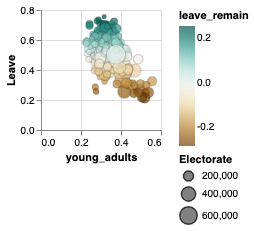

In [11]:
base_scatter = alt.Chart(gb_boundaries.iloc[:,6:]
    ).mark_circle(strokeWidth=1,stroke='black',strokeOpacity=0.2
    ).encode(
        x='young_adults:Q',
        y='Leave:Q',
        size='Electorate:Q',
        color=alt.Color('leave_remain:Q', scale=alt.Scale(scheme='brownbluegreen')),
        tooltip=['Region:N','Area:N']
    ).properties(
        width=120,
        height=120)
base_scatter

Compare the code below with the code above. Below we modify how we map a data variable to a visual variable, include some helper functions to define the scale of the vertical axis for every scatterplot (the *domain*), include the repeat function to generate multiple scatterplots and tell Altair how we want it to specify the scales for each scatterplot (*independently*).

To experiment with the visualisation, we can, for example, modify *resolve_scale*, switching from *independent* to *shared*, and see how each scatterplot looks afterwards.

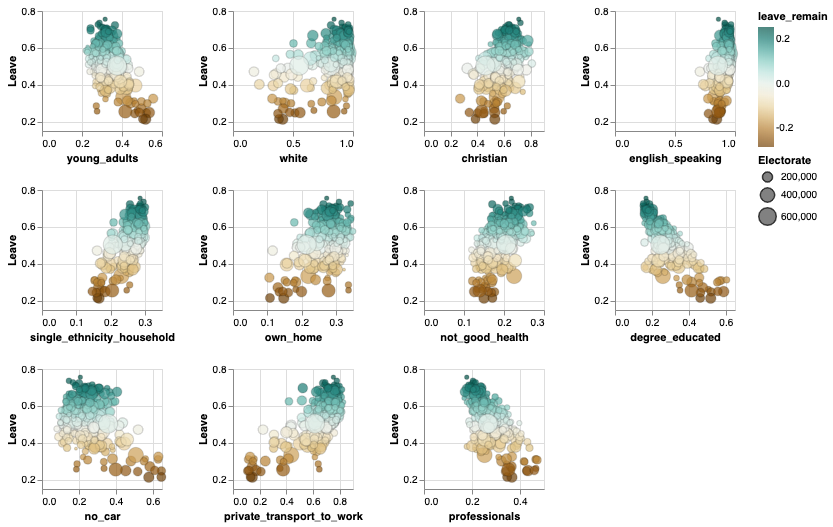

In [12]:
alt.Chart(gb_boundaries.iloc[:,6:]).mark_circle(strokeWidth=1,stroke='black',strokeOpacity=0.2).encode(
    x=alt.X(alt.repeat(), type='quantitative'),
    y=alt.Y('Leave:Q',scale=alt.Scale(domain=[0.15,0.8])),
    size='Electorate:Q',
    color=alt.Color('leave_remain:Q', scale=alt.Scale(scheme='brownbluegreen')),
    tooltip=['Region:N','Area:N']
).properties(
    width=120,
    height=120
).repeat(variables_to_compare,
    columns=4
).resolve_scale(x='independent',y='independent')

Altair also allows us to add interactive widgets and attach them to the visualisations. Below there is an example of the same series of scatterplots, with an additional dropdown that enables us to filter the scatterplot by region.

Take some time to understand the code and also read the [documentation](https://altair-viz.github.io/user_guide/interactions.html) if you want to know more about interactions with Altair. Note that due to the behaviour of the library we're using a workaround to filter the nodes: instead of removing them from view, we modify their opacity. This means that, when you hover the mouse, you will see that there are tooltips for invisible circles. If data points were actually removed from view, Altair would recalculate the colours and circle sizes, making it more difficult to compare the regions each time we selected a different one. Our *design choice* here is to preserve colour and size and tolerate the tooltips for invisible circles.

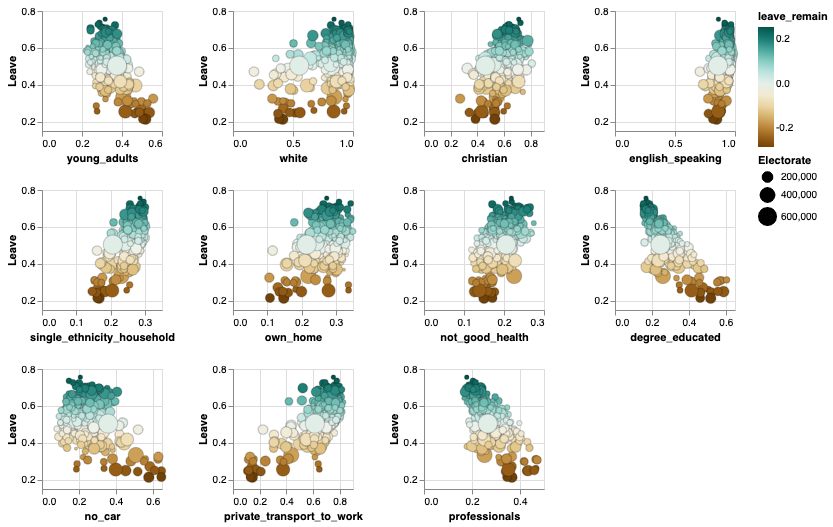

In [13]:
input_dropdown = alt.binding_select(options=gb_boundaries.Region.unique().tolist())
selection = alt.selection_single(fields=['Region'], bind=input_dropdown, name='Select')
opacity = alt.condition(selection,alt.value(1),alt.value(0)) #this tells Altair to set opacity to 1 (fully visible) for the selected 

alt.Chart(gb_boundaries.iloc[:,6:]).mark_circle(strokeWidth=1,stroke='black',strokeOpacity=0.2).encode(
    x=alt.X(alt.repeat(), type='quantitative'),
    y=alt.Y('Leave:Q',scale=alt.Scale(domain=[0.15,0.8])),
    size='Electorate:Q',
    color=alt.Color('leave_remain:Q', scale=alt.Scale(scheme='brownbluegreen')),
    opacity=opacity,
    tooltip=['Region:N','Area:N','Leave:Q']
).properties(
    width=120,
    height=120
).add_selection(
    selection
).repeat(variables_to_compare,
    columns=4
).resolve_scale(x='independent',y='independent'
)

### Explore for yourself

The relationships here are interesting. Relative levels of degree-level educational attainment are most correlated with share of Leave vote: we find compelling evidence for a negative linear relationship between % of residents in LAs with degrees and propensity of that LA to vote Leave. However, this is not always the case. There are certain LAs with relatively low levels of degree-level attainment but where the comparative share of the vote was in favour of Remain. 

* Try experimenting with the chart's design. For example, you may wish to colour the points by the `Region` variable -- this might give an indication as to whether outliers from the best fit line are spatially concentrated. 
* When making comparisons between Scottish data and that for GB as a whole what do you notice? Particularly look at change in the most discriminating variables: *professionals* and *degree_educated*.

If you want to change to a discrete hue-based colour scheme, you need to tell Altair the correct variable type and the appropriate colour scheme. For the full set of available colour schemes, check [here](https://vega.github.io/vega/docs/schemes/).

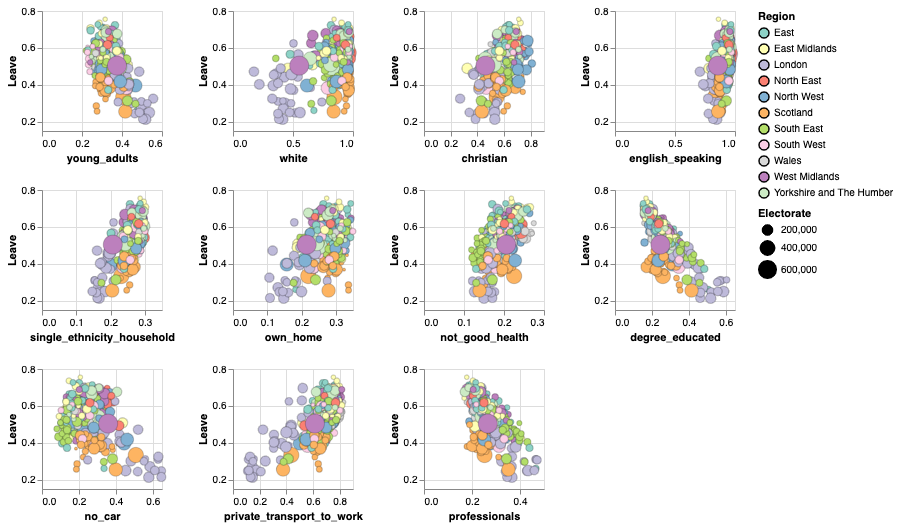

In [14]:
input_dropdown = alt.binding_select(options=gb_boundaries.Region.unique().tolist())
selection = alt.selection_single(fields=['Region'], bind=input_dropdown, name='Select')
opacity = alt.condition(selection,alt.value(1),alt.value(0.2)) #this tells Altair to set opacity to 1 (fully visible) for the selected points

alt.Chart(gb_boundaries.iloc[:,6:]).mark_circle(strokeWidth=1,stroke='black',strokeOpacity=0.2).encode(
    x=alt.X(alt.repeat(), type='quantitative'),
    y=alt.Y('Leave:Q',scale=alt.Scale(domain=[0.15,0.8])),
    size='Electorate:Q',
    color=alt.Color('Region:N', scale=alt.Scale(scheme='set3')),  ##Here is where we change the colour
    opacity=opacity,
    tooltip=['Region:N','Area:N','Leave:Q']
).properties(
    width=120,
    height=120
).add_selection(
    selection
).repeat(variables_to_compare,
    columns=4
).resolve_scale(x='independent',y='independent'
)

## Assumptions of linear regression and the case for local model(s)

Now we've found some variables that not only correlate with the share of Remain:Leave vote but also correspond to phenomena that might help explain the vote. We can try to build models to take account of the effects of these variables on the vote.

We will generate a multivariate regression model using the variables above that we hypothesise are discriminating. It's worth here quickly revisiting the assumptions of multivariate linear regression:

* Linear relationship between expected value of outcome and each explanatory variable
* No or limited collinearity of explanatory variables
* No (spatial) auto-correlation in residuals 
* Homoscedasticity (constant variance) in residuals
* Normality in distribution of residuals

We have already identified linearity in the relationships between our outcome and candidate explanatory variables and we'll discuss the distribution of model residuals shortly. However, we've yet to address the problem of collinearity of explanatory variables. Since we wish to develop a model for *explaining* voter preference, it's important that our model is parsimonious: that is, that we can explain the outcome with as few explanatory variables as possible. Attending to issues of collinearity helps us to do this: we can eliminate variables that effectively represent the same concept. 

Collinearity can initially be assessed through studying pairwise correlation between each explanatory variable -- the code below allows a matrix of pairwise correlation coefficients to be generated. 

In [15]:
model_variables =  ['Leave','young_adults', 'white',
       'christian', 'english_speaking', 'single_ethnicity_household',
       'own_home', 'not_good_health', 'degree_educated', 'no_car',
       'private_transport_to_work', 'professionals','pop_density']

corr_matrix = pd.melt(gb_boundaries[model_variables].corr(method='pearson').reset_index(),id_vars=['index'])

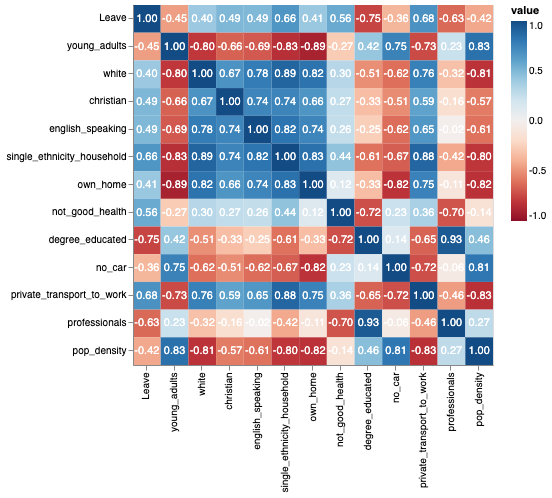

In [16]:
base = alt.Chart(corr_matrix).encode(
    x=alt.X('index:N',scale=alt.Scale(paddingInner=0),sort=alt.EncodingSortField('index', order='ascending')),
    y=alt.Y('variable:N',scale=alt.Scale(paddingInner=0),sort=alt.EncodingSortField('index', order='ascending')),
)

heatmap = base.mark_rect().encode(
    color=alt.Color('value:Q', scale=alt.Scale(domain=[-1,1],scheme='redblue')),
    tooltip=['value','index','variable']
    )

text = base.mark_text(baseline='middle').encode(
    alt.Text('value',format='.2f'),
    color=alt.value('white'),
    tooltip=['value','index','variable']
)

(heatmap + text).properties(width=360,height=360).configure_axis(title=None)

(Note how the code above takes a slightly different approach to create the charts, demonstrating the flexibility of *declarative* visualisation grammars. We first define a *skeleton* chart, defining only the X and Y variables we want to use, and assign it to variable *base*. We extend this base twice: to specify the heatmap itself and then to add the text labels. We then use the [layer operator](https://altair-viz.github.io/user_guide/compound_charts.html) from Altair, +, to combine the two charts.)

An established technique for identifying problems of collinearity within a multiple regression model itself is the [Variance Inflation Factor](https://en.wikipedia.org/wiki/Variance_inflation_factor) (VIF). VIF measures how much the __variance__ of the estimated regression coefficients are inflated as compared to when the explanatory variables are *not* linearly related. There are heuristics around the level of collinearity that can be tolerated for each variable: VIF values of 2-5 represent reasonably low levels of variance inflation due to collinearity and VIF >= 10 represent a tolerance threshold that should be avoided. A reasonable method for inclusion or exclusion of explanatory variables might be to:

* identify variables that appear to be discriminating (based on the strength of correlation against the outcome).
* identify variables which appear to co-vary *and* which are conceptually similar -- *degree_educated* and *professionals* would be the most obvious initial pair.
* explore the effect of removing the explanatory variable on VIF scores and model fit.

In this study we wish to develop a model for *understanding* spatial variations in voting preference. That the explanatory variables we use also represent separate concepts, and are few in number (so the model can be easily understood), is important. We don't in this practical detail in full the decision making process (there's already plenty to read!). However, the multivariate model we specify based on this process is:

`Leave ~ younger_adults + christian + english_speaking + degree_educated + white + no_car`

(This formula is based on a traditional notation that originates in R and is compatible with many libraries for statistical modelling. You can see more details about it [here](https://faculty.chicagobooth.edu/richard.hahn/teaching/formulanotation.pdf))

In your coursework projects we expect this decision-making to be made transparent. As well as making data-driven decisions (e.g. using correlation coefficients and VIF scores in this case), we'd expect a justification grounded in your data analysis context. 

Below we use code to join our list of variables together, so that we can have a dynamic way to try different models. You can do that by slicing the selected_variables array, or removing values and re-running the cell.

In [17]:
selected_variables =  ['Leave','young_adults', 'white',
       'christian', 'english_speaking', 'single_ethnicity_household',
       'own_home', 'not_good_health', 'degree_educated', 'no_car',
       'private_transport_to_work', 'professionals','pop_density']

str_model_variables = ' + '.join(selected_variables[1:]) #Note that we use :1 to remove Leave from the list, as it is the dependent variable

lm = smf.ols(formula='Leave ~ '+str_model_variables, data=gb_boundaries).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Leave   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     184.1
Date:                Thu, 31 Oct 2019   Prob (F-statistic):          1.32e-146
Time:                        15:14:13   Log-Likelihood:                 691.49
No. Observations:                 378   AIC:                            -1357.
Df Residuals:                     365   BIC:                            -1306.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [18]:
variables = lm.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
for i in range(len(selected_variables[1:])):
    display(Markdown('**'+selected_variables[i+1]+'**:' + str(vif[i+1])))

**young_adults**:8.756372615841869

**white**:10.035305724277766

**christian**:2.736166254969919

**english_speaking**:8.218765223011623

**single_ethnicity_household**:17.29457315328245

**own_home**:8.644401376219895

**not_good_health**:7.6514818202900745

**degree_educated**:19.322159754395432

**no_car**:16.706796155869764

**private_transport_to_work**:10.032419695332004

**professionals**:16.824157301377145

**pop_density**:8.035852865701969

### Exposing regional variation

A case can be made for local (or geographically-weighted) regression where there is spatial dependency in model residuals. Remembering that residuals are the difference between an observed outcome and that outcome estimated by the linear model, spatial clustering of, for instance, negative residuals -- where the model predicts a lower Leave vote than expected given socio-economic context -- suggests there is something particular about that local context. 

In [19]:
results_degree = smf.ols(formula='Leave ~ degree_educated',data=gb_boundaries).fit()

results_refined = smf.ols(formula='''Leave ~ young_adults + christian
                          + english_speaking + professionals + white + no_car''',data=gb_boundaries).fit()

gb_boundaries = gb_boundaries.assign(resids_degree = results_degree.resid)
gb_boundaries = gb_boundaries.assign(resids_refined = results_refined.resid)

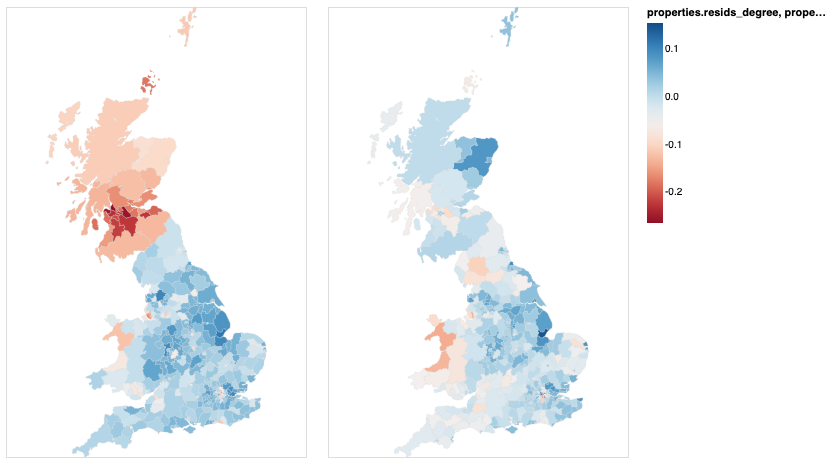

In [20]:
 alt.Chart(alt.InlineData(values = gb_boundaries.to_json(),
                       format = alt.DataFormat(property='features',type='json')) ).mark_geoshape(strokeWidth=1,stroke='lightgray',strokeOpacity=0.2
).encode(color=alt.Color(alt.repeat('column'), type='quantitative', scale=alt.Scale(scheme='redblue')),
    tooltip=['properties.Area:N',alt.Tooltip(alt.repeat("column"), type="quantitative")]
).properties(
    projection={'type': 'identity','reflectY': True},
    width=300,
    height=450
).repeat(column=['properties.resids_degree','properties.resids_refined'])

In our first model, there is an obvious spatial auto-correlation in residuals north of the border that suggests Scotland is a different category of location. The negative sign here means that our univariate model predicting the referendum vote as a linear function of the Local Authority *degree-educated* population, overestimates the Leave vote in Scotland. But when we add other variables into the model, this Scotland vs rest-of-country difference is far less pronounced. So we have begun to account for the difference in the way Scotland voted purely on the basis of these additional set of variables. Notice, though, that there is stil spatial-autocorrelation in the residuals across GB -- areas of blue and red generally concentrate together. 

### Explore for yourself

* When we only used *degree_educated*, our model for England and Wales was good, but not for Scotland. Explore other combinations of variables and study the model fits, VIF scores and correlations in conjunction with the maps.

## Exploring spatially-varying relationships using geographically-weighted statistics

We finish the practical by exploring whether and how relationships between our selected explanatory variables vary spatially using geographically-weighted (gw) statistics.

You will recall from the lecture that gw-statistics enable spatial variations in values, distributions and relationships between variables to be explored by generating local *models* (broadly defined) at each observation area -- each LA in this case. The technique involves a moving spatial window and weighting scheme such that nearby locations are given greater salience in the model. 

We'll generate gw-summary statistics by first fitting a model, then evaluating the results. The purpose here is to support understanding of how correlations between our outcome and explanatory variable change over space. And we'll inspect these correlation coefficient values by plotting them in Choropleth maps.

In [21]:
#GWR below requires the "centroids" of each geographical area
centroids = np.array([[c.x,c.y] for c in gb_boundaries.geometry.centroid])

#These are all the variables we want to apply geographically-weighted statistics
refined_vars = ["young_adults", "white" , "christian", "english_speaking", 
                "single_ethnicity_household", "own_home", "not_good_health", "degree_educated", "no_car", 
                "private_transport_to_work", "professionals"]
coeff_names = ['intercept']
map_vars = []
for var in refined_vars:
    coeff_names.append('coeff_'+var)
    map_vars.append('properties.coeff_'+var)

In [22]:
#Define GWR model
model = GWR(centroids,gb_boundaries['Leave'].to_numpy().reshape((-1,1))
            ,gb_boundaries[refined_vars].to_numpy(),bw=50,kernel='bisquare',fixed=False)
gw_results = model.fit()

In [23]:
#GWR or GWRResult does not calculate geographically-weighted correlation coefficients for all variables
#So we adapt our own function
def all_corr(results,variables):
    """
    Computes  local correlation coefficients (n, (((p+1)**2) + (p+1) / 2) within a geographically
    weighted design matrix
    Returns one array with the order and dimensions listed above where n
    is the number of locations used as calibrations points and p is the
    number of explanatory variables; +1 accounts for the dependent variable.
    Local correlation coefficient is not calculated for constant term.
    """
    #print(self.model)
    x = results.X
    y = results.y
    x = np.column_stack((x,y))
    w = results.W
    nvar = x.shape[1]
    nrow = len(w)
    if results.model.constant:
        ncor = (((nvar - 1)**2 + (nvar - 1)) / 2) - (nvar - 1)
        jk = list(combo(range(1, nvar), 2))
    else:
        ncor = (((nvar)**2 + (nvar)) / 2) - nvar
        jk = list(combo(range(nvar), 2))
    corr_mat = np.ndarray((nrow, int(ncor)),dtype=dict)
    
    for i in range(nrow):
        wi = w[i]
        sw = np.sum(wi)
        wi = wi / sw
        tag = 0

        for j, k in jk:
            val = corr(np.cov(x[:, j], x[:, k], aweights=wi))[0][1] 
            corr_mat[i,tag] = {"var": variables[j-1]+"_"+variables[k-1], "var_1": variables[j-1], "var_2": variables[k-1], "value": val}
            tag = tag + 1
            
    return corr_mat

In [24]:
corr_matrix = all_corr(gw_results,refined_vars+['Leave'])
#Filter only those correlation coefficients against the Leave vote
corr_2 = [{d['var']: d['value'] for d in x if d['var_2'] == 'Leave'} for x in corr_matrix]
corr_coeffs = pd.DataFrame.from_records(corr_2)

In [25]:
#Check if we have what we wanted (all variables correlated with Leave)
corr_coeffs.head()

young_adults_Leave  white_Leave  christian_Leave  english_speaking_Leave  \
0           -0.272977     0.448262         0.488468                0.633269   
1           -0.489447     0.281828         0.562300               -0.077148   
2           -0.263900     0.095990         0.379267                0.006428   
3           -0.314278     0.185083         0.070528                0.085439   
4           -0.085391     0.168854         0.264475                0.069085   

   single_ethnicity_household_Leave  own_home_Leave  not_good_health_Leave  \
0                          0.707520        0.087977               0.545547   
1                          0.654490        0.437352               0.842521   
2                          0.433343        0.194651               0.734683   
3                          0.431903        0.331045               0.389133   
4                          0.224415       -0.151247               0.657184   

   degree_educated_Leave  no_car_Leave  private_transport_to_work_Leave  \
0              -0.443554     -0.247502                         0.545193   
1              -0.969710     -0.147410                         0.789762   
2              -0.887069      0.049972                         0.659010   
3              -0.530288     -0.202253                         0.576025   
4              -0.839289      0.377051                         0.564091   

   professionals_Leave  
0            -0.525329  
1            -0.936784  
2            -0.778870  
3            -0.442164  
4            -0.799127

In [26]:
corr_df = pd.merge(gb_boundaries,corr_coeffs,left_index=True,right_index=True)
map_vars = ['properties.'+v for v in corr_coeffs.columns.values ]
corr_geo = alt.InlineData(values = corr_df.to_json(),
                       format = alt.DataFormat(property='features',type='json'))

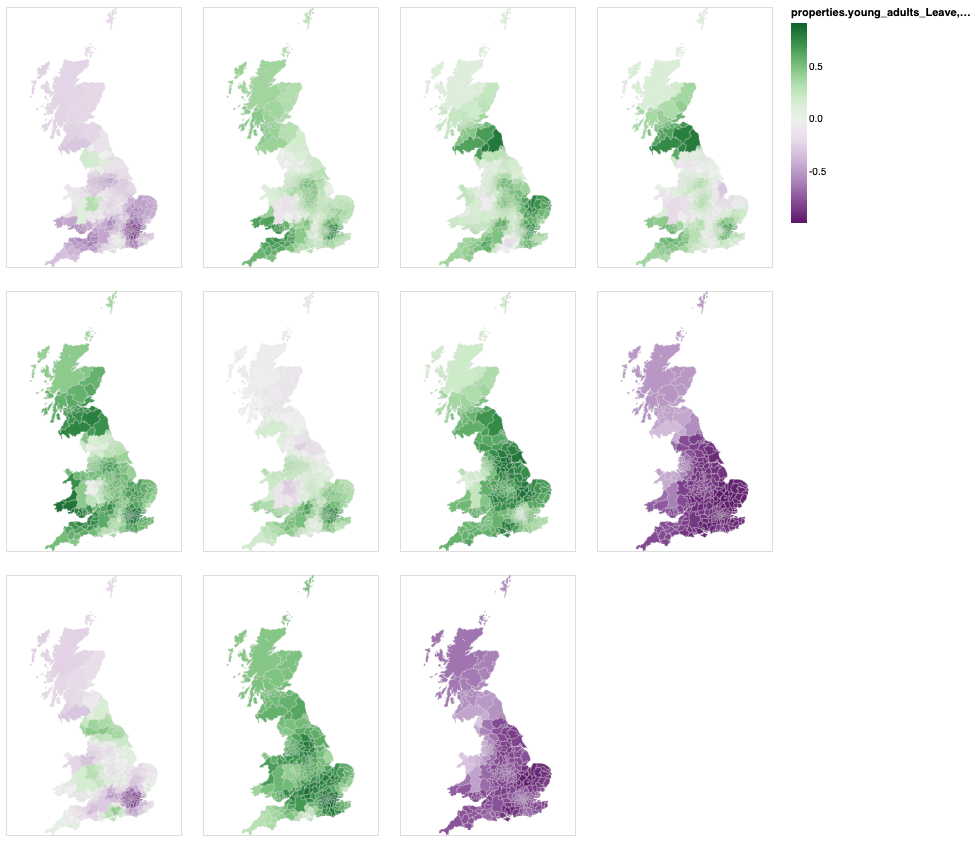

In [27]:
alt.Chart(corr_geo 
).mark_geoshape(strokeWidth=1,stroke='lightgray',strokeOpacity=0.2
).encode(color=alt.Color(alt.repeat('repeat'), type='quantitative', scale=alt.Scale(scheme='purplegreen')),
    tooltip=['properties.Area:N',alt.Tooltip(alt.repeat("repeat"), type="quantitative")]
).properties(
    projection={'type': 'identity','reflectY': True},
    width=175,
    height=260,
).repeat(map_vars,columns=4)

The maps confirm that *degree-educated* (second-to-last row, last column) and *professionals* (last map) are strongly negatively correlated with the Leave vote (the intepretation of this is that a HIGHER proportion of people with degrees correlates with a SMALLER proportion of vote for Leave). Although the strength of relationship varies – e.g. Scotland for *degree-educated* and to a lesser extent *professionals* and London, Leicester and parts of the North West for *professionals* – the direction of the relationship (the sign of the coefficients) remains the same. *Private transport to work* and *not good health* are both associated positively with Leave. This appears to be particularly so for the East and North of England (not good health) and London and LAs surrounding Oxford, Cambridge, Bristol and Leeds. From a cursory glance at the maps, there is a sense of London’s unique context. The *no car* variable is very strongly negatively associated with Leave around London; elsewhere this variable is less discriminating and in fact is positively associated with Leave in the North East.

Scanning across the maps and making systematic claims about combinations of relationships is challenging. Clustering LAs on their gw-correlation coefficients might help. In the code below, each LA is summarised according to its geographically-weighted correlation coefficient and agglomerative hierarchical cluster analysis (HCA) is used to identify groups of LAs that share *similar combinations of relationship*. LAs are then ‘agglomerated’ into groups iteratively by merging the most similar LAs. This continues until all LAs are merged into a single group. We can evaluate the clustering visually by plotting a dendrogram depicting this agglomeration process, and numerically by considering Average Silhouette Width (ASW) values, calculated at different cuts (number of clusters) of the dendrogram. 

We won't go into length about the choice of cluster analysis: if two variables are included that represent the same concept, then that concept is given undue weight. Variables were carefully selected by visually inspecting correlation matrices of the geographically-weighted correlation coefficients – similar to the approach for assessing collinearity in regression. The input variables selected via this process are: __Christian, degree-educated, no car, not good health, white.__



In [28]:
#First we standardise the variables
cluster_variables = ['christian_Leave', 'degree_educated_Leave' ,'no_car_Leave','not_good_health_Leave' , 'white_Leave' ]
scaler = StandardScaler()
scaled_coefficients=scaler.fit_transform(corr_coeffs[cluster_variables])
scaled_df = pd.DataFrame(scaled_coefficients,columns=corr_coeffs[cluster_variables].columns)

In [29]:
cluster_results = [None]*12
for i in range(2,12): 
    ac =  AgglomerativeClustering(linkage='ward', n_clusters=i)
    cr = ac.fit(scaled_df.values)
    cluster_results[i] = cr
    print(str(i)+" clusters. Avg silhouette score:",silhouette_score(scaled_df.values,cr.labels_))

2 clusters. Avg silhouette score: 0.32432981144902695
3 clusters. Avg silhouette score: 0.3287492209582552
4 clusters. Avg silhouette score: 0.3093710651622908
5 clusters. Avg silhouette score: 0.3174879610477369
6 clusters. Avg silhouette score: 0.30453128132123203
7 clusters. Avg silhouette score: 0.3119976375595492
8 clusters. Avg silhouette score: 0.3182322199474793
9 clusters. Avg silhouette score: 0.30843004114119726
10 clusters. Avg silhouette score: 0.3243508458031118
11 clusters. Avg silhouette score: 0.31986323795181654


We can then visually inspect the silhouette scores plot for each solution. By re-running the next three blocks of code for each solution, we will see how there is not a definitive perfect solution. Remember that for each member of a cluster (Local Authorities), a negative value might suggest that the LA is in the wrong cluster. With 4 clusters, cluster 1 only has positive values, but cluster 0 has some really bad silhouette scores. Increasing to 5, we can see that cluster 1 is actually slightly worse, but cluster 0 improves significantly. As our aim here is to understand more the differences between the Leave vote in LA's based on geography and census variables, it is natural that some areas are more difficult to "place" in a single cluster.

At this point, we could also conclude that traditional clustering techniques are not helpful and move towards a "fuzzy" clustering solution: where a Local Authority belongs with different degrees of membership to various clusters. But we leave that for braver data scientists adventurers to explore :)

In [30]:
hc_result =  cluster_results[5] 
corr_df['cluster_membership'] = hc_result.labels_
corr_coeffs['cluster_membership'] = hc_result.labels_

In [31]:
sil_scores = pd.DataFrame(
    np.column_stack((silhouette_samples(scaled_df.values,hc_result.labels_),hc_result.labels_))
    ,columns=['silhouette','cluster_m']).reset_index()

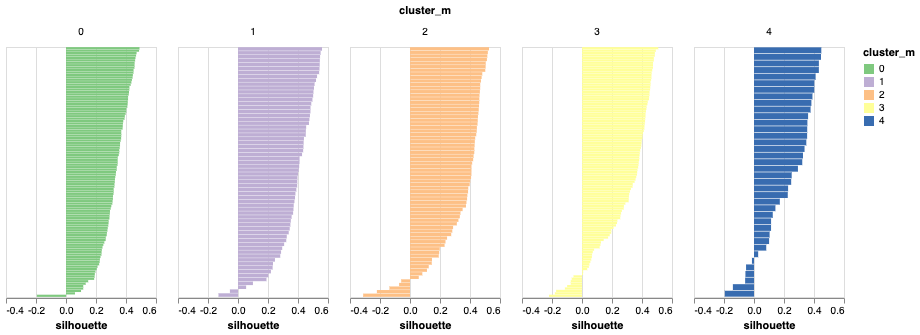

In [32]:
alt.Chart(sil_scores).mark_bar(
        ).encode(
            x='silhouette:Q',
            y=alt.Y('index:O',sort=alt.SortField(field="silhouette", order='descending'),axis=None),
            color=alt.Color('cluster_m:N',scale=alt.Scale(scheme='accent')),
            facet='cluster_m:N'
        ).properties(width=150,height=250).resolve_scale(y='independent')

Below the cluster memberships are displayed on a choropleth map and described on the variables on which they were defined via density plots. We’ve also come up with cluster labels that try to characterise these distributions. This of course requires knowledge besides that which comes from the census variables; in the individual coursework, it is helpful to choose datasets for which you do have this "extra" knowledge if you intend to add additional *domain* discussions to the analysis.

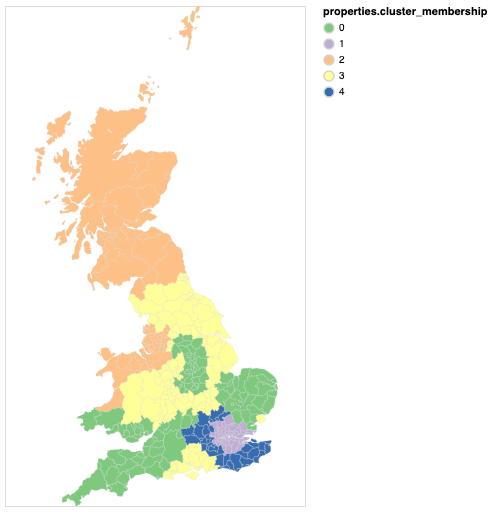

In [33]:
alt.Chart(alt.InlineData(values = corr_df.to_json(),
                       format = alt.DataFormat(property='features',type='json')) 
         ).mark_geoshape(strokeWidth=1,stroke='lightgray',strokeOpacity=0.2
        ).encode(
            color=alt.Color('properties.cluster_membership:N',scale=alt.Scale(scheme='accent')),
            tooltip=['properties.Area:N','properties.cluster_membership:N']
        ).properties(
            projection={'type': 'identity','reflectY': True},
            width=300,
            height=500,
        )

The code below is prepared for 5 clusters, but it is easy to change according to the number of clusters if we wish to test others. The truly hardcoded line is the last one, which assembles the complete chart. But that technically is not necessary. To display cluster groups charts individually, it is enough to write in a code cell `display(chart[i])`

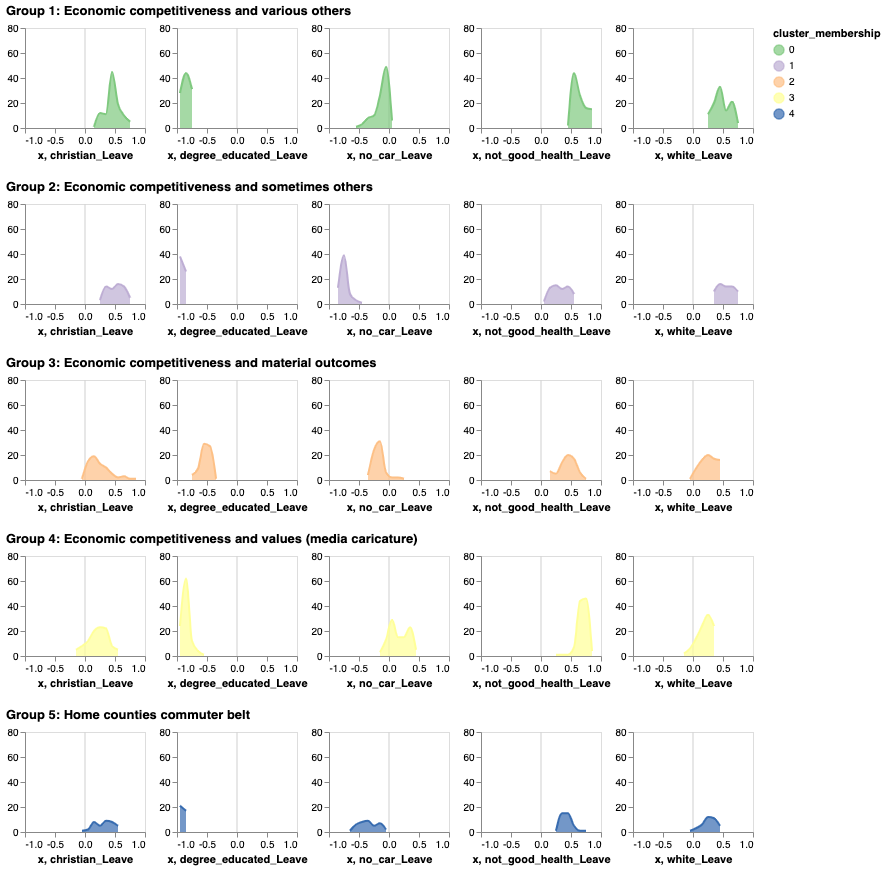

In [34]:
names = ['Group 1: Economic competitiveness and various others'
         ,'Group 2: Economic competitiveness and sometimes others'
        , 'Group 3: Economic competitiveness and material outcomes',
        'Group 4: Economic competitiveness and values (media caricature)',
        'Group 5: Home counties commuter belt']
charts = []
for i in range(len(names)):

    c1 = alt.Chart(pd.DataFrame([{"x": 0}])).mark_rule().encode(x=alt.X('x:Q'),color=alt.value('lightgray'))
    
    c2 =  alt.Chart(corr_coeffs
            ).transform_filter(
                alt.datum.cluster_membership == i
            ).mark_area(interpolate='monotone',line=True
            ).encode(
                y=alt.Y('count()',title=None,scale=alt.Scale(domain=[0,80])),
                color=alt.Color('cluster_membership:O',scale=alt.Scale(scheme='accent'))
            ).properties(width=120,height=100)
    
    chart = (c1+c2
          ).encode(
                x=alt.X(alt.repeat('repeat'),type='quantitative',
                        bin=alt.Bin(extent=[-1.0,1.0],step=0.1),
                        scale=alt.Scale(domain=[-1,1]),
                        axis=alt.Axis(tickCount=4,labelOverlap=False))
          ).repeat(cluster_variables,
                    spacing=0
          ).resolve_scale(y='shared'
          ).properties(title=names[i])
          
    
    charts.append(chart)
    
(charts[0] & charts[1] & charts[2] & charts[3] & charts[4]).configure(fieldTitle='plain').configure_axis(
    grid=False
)

### Data analysis limitations and immediate follow-up questions
* What are the limitations of this study? For example, remember we’re not looking at individual data, we’re using LA-level population data and vote results.
* What phenomena and concepts are not captured well by our 2011 Census variables?
* How conclusive is our analysis?

## Further reading

* Bartholomew, D. J., Steele, F., Galbraith, J. & Moustaki, I. (2008), **[Analysis of Multivariate Social Science Data](http://www.lse.ac.uk/statistics/research/Social-Statistics/Multivariate-Data-Analysis/Second-Edition.aspx)**, Second Edition, 2 edn, Chapman and Hall/CRC Press, London.
* Goodwin, M. and Heath, O. (2016), **[The 2016 Referendum, Brexit and the Left Behind: An Aggregate-level Analysis of the Result](http://onlinelibrary.wiley.com/doi/10.1111/1467-923X.12285/full)**, *The Political Quarterly*, 87:323–332.
* Beecham, R., Slingsby, A. and Brunsdon, C. (2018). **[Locally-varying explanations behind the United Kingdom’s vote to the Leave the European Union](http://openaccess.city.ac.uk/id/eprint/19048/)**. *Journal of Spatial Information Science*, 16, pp. 117-136.
